<a href="https://colab.research.google.com/github/Eddy-Emmanuel/Medical-Image-Multi-Label-Classification-Pytorch/blob/main/Medical_Image_Multi_Label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bone-break-classification-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4257126%2F7394372%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T215638Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D92365532c2db45e8f84d9b4e92ca60b86c321e115d76ce01e616049448ccf823c3da7e92883320e4d670259d9037e23dbce475fbc946ab7cf3b79c25c20279831e0b8848c97adb9dcb3a1e0cadda13e18db4799ae9e64e9dc9ac6dc68243bf8e72b6d9e3858d19c44a365b5b89ed3040d11b9b60d48d42ee5e9cb2e6632505c759b86b38ed6a38e8c1d3c26e4b5dd597326c4945742123aaeef7550896a7c63eb96c18d808ddccbc19d2e31e97a3a5e4ad129cf724936444010b8051aab2d5910055f3af8bbbc107a909ecea65fa769efa382387a487d8fe6e70f63576270fe389e21543c0deffa048a13a225e8b52c5d126d18342691f1bb049e50c4b8081c5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 29830546 bytes downloaded
Downloaded and uncompressed: bone-break-classification-image-dataset
Data source import complete.


In [4]:
!pip install torchinfo

In [5]:
from glob import glob

import copy
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torchinfo
import torchvision
from torch import nn
from PIL import Image
import albumentations as A
from torch.optim import Adam
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(device)

cuda:0


In [6]:
def load_df(split_type) -> pd.DataFrame:
    image_path = glob("/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/*/{}/*".format(split_type))
    label = [i.split("/")[-3] for i in image_path]

    df = pd.DataFrame({
        "image_path": image_path,
        "label": label
    })

    return df

In [7]:
train_df = load_df("Train")
test_df = load_df("Test")

print(train_df.shape, test_df.shape)

(989, 2) (140, 2)


In [8]:
train_df.head()

,image_path,label
0,/kaggle/input/bone-break-classification-image-...,Oblique fracture
1,/kaggle/input/bone-break-classification-image-...,Oblique fracture
2,/kaggle/input/bone-break-classification-image-...,Oblique fracture
3,/kaggle/input/bone-break-classification-image-...,Oblique fracture
4,/kaggle/input/bone-break-classification-image-...,Oblique fracture


In [9]:
train_df["label"].value_counts()

label
Fracture Dislocation     137
Comminuted fracture      134
Pathological fracture    116
Avulsion fracture        109
Greenstick fracture      106
Hairline Fracture        101
Impacted fracture         75
Spiral Fracture           74
Oblique fracture          69
Longitudinal fracture     68
Name: count, dtype: int64

In [10]:
encoder = LabelEncoder()

train_df["categorical_label"] = encoder.fit_transform(train_df["label"])
test_df["categorical_label"] = encoder.fit_transform(test_df["label"])

In [11]:
class_indices = {j:i for i, j in zip(encoder.classes_, range(len(encoder.classes_)))}
class_indices

{0: 'Avulsion fracture',
 1: 'Comminuted fracture',
 2: 'Fracture Dislocation',
 3: 'Greenstick fracture',
 4: 'Hairline Fracture',
 5: 'Impacted fracture',
 6: 'Longitudinal fracture',
 7: 'Oblique fracture',
 8: 'Pathological fracture',
 9: 'Spiral Fracture'}

In [12]:
class DATA(Dataset):
    def __init__(self, df, aug=None):
        super(DATA, self).__init__()
        self.X = df["image_path"]
        self.y = df["categorical_label"]

        if not aug:
            self.aug = A.Compose([
                A.Resize(height=256, width=256),
                A.Normalize() # For grayscale mean=0.5 snd std=0.5
            ])

        else:
            self.aug = A.Compose([
                A.RandomRotate90(),
                A.RandomBrightnessContrast(),
#                 A.RandomCrop(),
                A.HorizontalFlip(),
                A.Resize(height=256, width=256),
                A.Normalize(mean=0.5, std=0.5, always_apply=True)
            ])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        loaded_image = Image.open(self.X[index]).convert("RGB") # "L" for gray
        image_label = self.y[index]
        augmented_image = self.aug(image=np.array(loaded_image))["image"]
        permute_image = torch.permute(torch.Tensor(augmented_image), (2, 1, 0))
        return permute_image, image_label

In [39]:
train_data = DATA(df=train_df)
test_data = DATA(df=test_df)

In [40]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=True)

In [41]:
image_batch, label_batch = next(iter(train_dataloader))

image_batch.shape, label_batch.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

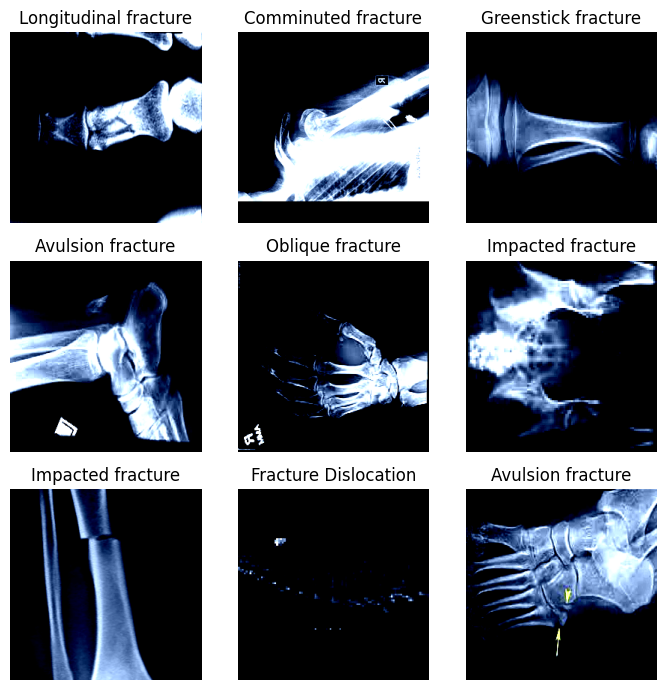

In [42]:
random_index = np.random.randint(low=0, high=label_batch.size()[0], size=9)

plt.figure(figsize=(7, 7))
for idx, plt_idx in enumerate(random_index, start=1):
    plt.subplot(3, 3, idx)
    plt.imshow(torch.permute(image_batch[plt_idx], (1, 2, 0)), cmap="gray")
    plt.title(f"{class_indices[label_batch[plt_idx].item()]}")
    plt.axis(False)

plt.tight_layout()
plt.show()

## Model

In [43]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, momentum=0.9):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels, momentum=momentum)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout2d(p=0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        return x

class DenseBlock(nn.Module):
    def __init__(self, in_features, out_features, momentum=0.9):
        super(DenseBlock, self).__init__()
        self.dense = nn.Linear(in_features, out_features)
        self.batchnorm = nn.BatchNorm1d(out_features, momentum=momentum)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.dense(x)
        x = self.batchnorm(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        return x

class MedicalImageModel(nn.Module):
    def __init__(self):
        super(MedicalImageModel, self).__init__()
        self.conv1 = ConvBlock(3, 32)
        self.conv2 = ConvBlock(32, 64)
        self.conv3 = ConvBlock(64, 128)
        self.conv4 = ConvBlock(128, 256)
        self.flatten = nn.Flatten()
        self.dense1 = DenseBlock(256 * 16 * 16, 100)
        self.dense2 = nn.Linear(100, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x

In [44]:
MIM = MedicalImageModel()

torchinfo.summary(MIM, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
MedicalImageModel                        [32, 10]                  --
├─ConvBlock: 1-1                         [32, 32, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 128, 128]        64
│    └─LeakyReLU: 2-3                    [32, 32, 128, 128]        --
│    └─Dropout2d: 2-4                    [32, 32, 128, 128]        --
├─ConvBlock: 1-2                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 64, 64, 64]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 64, 64]          128
│    └─LeakyReLU: 2-7                    [32, 64, 64, 64]          --
│    └─Dropout2d: 2-8                    [32, 64, 64, 64]          --
├─ConvBlock: 1-3                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-9                       [32, 128, 32, 32]         73,856
│    

## Training loop

In [92]:
class MedicalImageClassifier(nn.Module):
    def __init__(self, model, optim_func, loss_func, device):
        super(MedicalImageClassifier, self).__init__()
        self.model = model
        self.device = device
        self.loss_func = loss_func
        self.optim_func = optim_func

    def train_batch_of_image(self, train_dataloader):
        total_loss_train = 0
        total_accuracy_train = 0
        num_of_prediction = 0

        self.model.train()

        for img, lbl in tqdm(train_dataloader, total=(len(train_dataloader)), desc="Training..."):

            img, lbl = img.to(self.device), lbl.to(self.device)

            self.optim_func.zero_grad()

            model_prediction = self.model(img)

            prediction_loss = self.loss_func(model_prediction, lbl)

            prediction_loss.backward()

            self.optim_func.step()

            n_correct = torch.sum(torch.argmax(model_prediction, dim=1)==lbl, dtype=torch.float).item()

            total_accuracy_train += n_correct

            total_loss_train += prediction_loss.item()

            num_of_prediction += len(model_prediction)

        return total_accuracy_train/num_of_prediction, total_loss_train/len(train_dataloader)


    @torch.inference_mode()
    def validate_batch_of_image(self, test_dataloader):
        total_loss_test = 0
        total_accuracy_test = 0
        num_of_prediction = 0

        self.model.eval()

        for img, lbl in tqdm(test_dataloader, total=len(test_dataloader), desc="Validation..."):

            img, lbl = img.to(self.device), lbl.to(self.device)

            model_prediction = self.model(img)

            prediction_loss = self.loss_func(model_prediction, lbl)

            n_correct = torch.sum(torch.argmax(model_prediction, dim=1)==lbl, dtype=torch.float).item()

            total_accuracy_test += n_correct

            total_loss_test += prediction_loss.item()

            num_of_prediction += len(model_prediction)

        return total_accuracy_test/num_of_prediction, total_loss_test/len(test_dataloader)


    def TrainModel(self, epochs, train_dataloader, test_dataloader):
        history = {
            "train_accuracy":[],
            "train_loss":[],
            "test_accuracy":[],
            "test_loss":[]
        }

        for epoch in range(1, epochs+1):
            train_acc, train_loss = self.train_batch_of_image(train_dataloader)
            test_acc, test_loss = self.validate_batch_of_image(test_dataloader)

            print("test acc", test_acc, "test loss", test_loss)

            history["train_accuracy"].append(train_acc)
            history["test_accuracy"].append(test_acc)
            history["train_loss"].append(train_loss)
            history["test_loss"].append(test_loss)

        return {"history":history, "model":self.model}

In [93]:
OPTIMIZER = Adam(MIM.parameters(), lr=0.0005)
LOSS_FUNCTION = nn.CrossEntropyLoss()

img_classifier = MedicalImageClassifier(model=MIM,
                                        optim_func=OPTIMIZER,
                                        loss_func=LOSS_FUNCTION,
                                        device=device)

In [94]:
result = img_classifier.TrainModel(epochs=20,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader)

Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2857142857142857 test loss 2.185785245895386


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.22857142857142856 test loss 2.2309879302978515


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.29285714285714287 test loss 2.1838106155395507


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2785714285714286 test loss 2.178177261352539


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2857142857142857 test loss 2.1640540599822997


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2785714285714286 test loss 2.187475347518921


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.3142857142857143 test loss 2.1433718681335447


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2714285714285714 test loss 2.165413761138916


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2857142857142857 test loss 2.1759994506835936


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2357142857142857 test loss 2.2081671714782716


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2571428571428571 test loss 2.174081039428711


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2785714285714286 test loss 2.188048315048218


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2785714285714286 test loss 2.1654027938842773


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2642857142857143 test loss 2.1753554821014403


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2714285714285714 test loss 2.164032220840454


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.25 test loss 2.1488816499710084


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2571428571428571 test loss 2.203228998184204


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2785714285714286 test loss 2.18680477142334


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2857142857142857 test loss 2.1691308498382567


Training...:   0%|          | 0/31 [00:00<?, ?it/s]

Validation...:   0%|          | 0/5 [00:00<?, ?it/s]

test acc 0.2857142857142857 test loss 2.1584598064422607


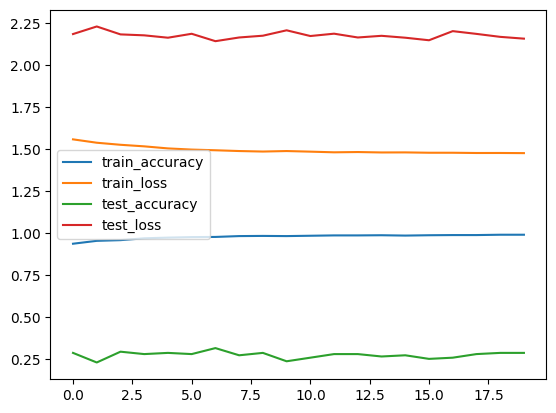

In [96]:
pd.DataFrame(result["history"]).plot()
plt.show()

## Eddy